In [1]:
! pip3 install transformers

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.5 MB 47.8 MB/s 
     |████████████████████████████████| 77 kB 7.2 MB/s 
     |████████████████████████████████| 596 kB 59.1 MB/s 
     |████████████████████████████████| 895 kB 52.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)

from transformers import (
    AutoTokenizer, 
    AutoModel,
    get_linear_schedule_with_warmup,
    BertModel,
    BertTokenizer,
    BertTokenizerFast
)

In [3]:
import json
import pandas as pd
import numpy as np
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
citation = pd.DataFrame(columns=['Text_Tokens','Cit_func','citseg_id'])
citation

,Text_Tokens,Cit_func,citseg_id


In [6]:
import os
paths=[]
#d = "/content/per_func_map_organised_small_11class/all"
d="/content/drive/MyDrive/per_func_map_organised_small_11class/all"
for path in os.listdir(d):
    full_path = os.path.join(d, path)
    if os.path.isfile(full_path):
        paths.append(full_path)

**Reading Data from dataset**

In [7]:
for i in range(len(paths)):
  path = paths[i]
  print(path)
  f=open(path)
  data=json.load(f)
  for i in data.values():
    citation_contexts=i['citation_contexts']
    for j in range(len(citation_contexts)):
      a=[]
      tokens=citation_contexts[j]['citance']['tokens_pp']
      left = citation_contexts[j]['left_ctx']
      left_tokens=[]
      for l in range(len(left)):
        left_tokens.append(left[l]['tokens_pp'])
      right = citation_contexts[j]['right_ctx']
      right_tokens=[]
      for r in range(len(right)):
        right_tokens.append(right[r]['tokens_pp'])
      
      left_tokens=[item for tokens in left_tokens for item in tokens]
      right_tokens=[item for tokens in right_tokens for item in tokens]
      l=len(left_tokens)
      tokens = left_tokens + tokens + right_tokens
      for cit_refs in range(len(citation_contexts[j]['cit_refs'])):
         citseg_id=citation_contexts[j]['cit_refs'][cit_refs]['citseg_id']
         if citseg_id not in  a:
            a.append(citseg_id)
            c=citation_contexts[j]['cit_refs'][cit_refs]['citseg_id']
            c = c + l
            f=citation_contexts[j]['cit_refs'][cit_refs]['function_agreed']
            citation = citation.append({'Text_Tokens':tokens, 'Cit_func':f,'citseg_id':c},ignore_index=True)

/content/drive/MyDrive/per_func_map_organised_small_11class/all/Future.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Support.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Basis.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoGM.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoRes.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoXY.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Motivation.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Neutral.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Similar.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_sm

**Joining Tokens of text**

In [8]:
df=citation['Text_Tokens'].tolist()
str1 = [' '.join([str(i) for i in y]) for y in df]
citation['text']=str1

In [9]:
citation.head()

,Text_Tokens,Cit_func,citseg_id,text
0,"[Despite, their, large, length, difference, ,, the, two, 0002, sentences, are, still, aligned, as, a, 1, -, 1, pair, ,, because, the, sentences, in, the, following, 4, alignments, (, 0003, -, 0003, ;, 0004, -, 0004, ,, 0005, ;, 0005, -, 0006, ;, 0006, -, 0007, ), have, rather, similar, HTML, markups, and, are, taken, by, the, program, to, be, the, most, likely, alignments, ., Beside, HTML, mar...",Future,97,"Despite their large length difference , the two 0002 sentences are still aligned as a 1 - 1 pair , because the sentences in the following 4 alignments ( 0003 - 0003 ; 0004 - 0004 , 0005 ; 0005 - 0006 ; 0006 - 0007 ) have rather similar HTML markups and are taken by the program to be the most likely alignments . Beside HTML markups , other criteria may also be incorporated . For example , it wo..."
1,"[Previous, work, has, argued, that, initiative, affects, the, degree, of, control, an, agent, has, in, the, dialogue, interaction, (, CITSEG, ), ., Thus, ,, a, cooperative, system, may, adopt, different, strategies, to, achieve, the, same, goal, depending, on, the, initiative, distribution, ., Since, task, initiative, models, contribution, to, domain, /, problemsolving, goals, ,, while, dialog...",Future,84,"Previous work has argued that initiative affects the degree of control an agent has in the dialogue interaction ( CITSEG ) . Thus , a cooperative system may adopt different strategies to achieve the same goal depending on the initiative distribution . Since task initiative models contribution to domain / problemsolving goals , while dialogue initiative affects the cur -5 An alternative strateg..."
2,"[In, this, paper, we, have, provided, an, original, mathematical, argument, in, favour, of, this, thesis, ., Our, results, hold, for, bilexical, context, -, free, grammars, and, directly, transfer, to, several, language, models, that, can, be, seen, as, stochastic, versions, of, this, formalism, (, see, Section, 1, ), ., We, perceive, that, these, results, can, be, extended, to, other, languag...",Future,82,In this paper we have provided an original mathematical argument in favour of this thesis . Our results hold for bilexical context - free grammars and directly transfer to several language models that can be seen as stochastic versions of this formalism ( see Section 1 ) . We perceive that these results can be extended to other language models that properly embed bilexical context - free gramm...
3,"[In, this, paper, we, have, provided, an, original, mathematical, argument, in, favour, of, this, thesis, ., Our, results, hold, for, bilexical, context, -, free, grammars, and, directly, transfer, to, several, language, models, that, can, be, seen, as, stochastic, versions, of, this, formalism, (, see, Section, 1, ), ., We, perceive, that, these, results, can, be, extended, to, other, languag...",Future,86,In this paper we have provided an original mathematical argument in favour of this thesis . Our results hold for bilexical context - free grammars and directly transfer to several language models that can be seen as stochastic versions of this formalism ( see Section 1 ) . We perceive that these results can be extended to other language models that properly embed bilexical context - free gramm...
4,"[Future, work, will, involve, testing, our, approach, with, higher, -, discrimination, datasets, ,, developing, methods, to, pre-process, review, texts, (, e.g., ,, improved, negation, tagging, ,, and, incorporating, partof, -, speech, tagging, ), ,, and, further, addressing, the, problem, of, overfitting, ., To, this, effect, we, will, investigate, different, feature, selection, algorithms, ,...",Future,76,"Future work will involve testing our approach with higher - discrimination datasets , developing methods to pre-process review texts ( e.g. , improved negation tagging , and incorporating partof - speech tagging ) , and further addressing the problem of overfitting . To this effect we wi

**Visualising Citation Function Present**

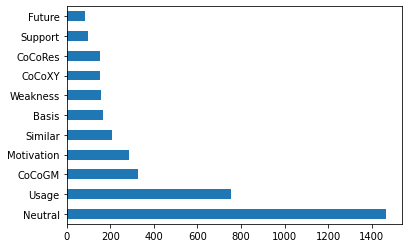

In [10]:
citation.Cit_func.value_counts().plot(kind='barh')

In [11]:
display(citation.Cit_func.value_counts())             
print(" ")

Neutral       1463
Usage          755
CoCoGM         328
Motivation     288
Similar        207
Basis          167
Weakness       158
CoCoXY         152
CoCoRes        151
Support        100
Future          85
Name: Cit_func, dtype: int64

**Dropping some rows of Neutral and Usage functions**

In [12]:
citation.drop(citation.query('Cit_func == "Neutral" ').sample(n=400).index,inplace=True)
citation.drop(citation.query('Cit_func == "Usage" ').sample(n=100).index,inplace=True)

In [13]:
unique_labels = citation.Cit_func.unique()
unique_labels

array(['Future', 'Support', 'Basis', 'CoCoGM', 'CoCoRes', 'CoCoXY',
       'Neutral', 'Motivation', 'Similar', 'Usage', 'Weakness'],
      dtype=object)

**One- hot encoding for labels**

In [14]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(unique_labels)

citation['label'] = le.transform(citation.Cit_func)

In [15]:
#Shuffling the dataframe
citation = citation.sample(frac=1).reset_index(drop=True)

**Splitting the dataset**

In [16]:
#split the subset by rating to create new train, val and test splits
import collections
by_rating = collections.defaultdict(list)
for _,row in citation.iterrows():
  by_rating[row.Cit_func].append(row.to_dict())

In [17]:
#create split data
seed =1021
final_list = []
np.random.seed(seed)
train_proportion = 0.7
val_proportion = 0.2
test_proportion = 0.1


for _, item_list in sorted(by_rating.items()):
  np.random.shuffle(item_list)

  n_total = len(item_list)
  n_train = int(train_proportion * n_total)
  n_val = int(val_proportion * n_total)
  n_test = int(test_proportion * n_total)


  #give data points  split attribute

  for item in item_list[:n_train]:
    item['split'] = 'train'

  for item in item_list[n_train:n_train+n_val]:
    item['split'] = 'val'

  for item in item_list[n_train+n_val:n_train+n_val+n_test]:
   item['split'] = 'test'


  #Add to final list

  final_list.extend(item_list)


citation = pd.DataFrame(final_list)

In [18]:
citation.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split
0,"[Our, approach, for, sentential, paraphrase, extraction, is, related, to, the, one, introduced, by, CITSEG, ,, who, also, employ, multiple, sequence, alignment, (, MSA, ), ., However, ,, they, use, MSA, at, the, sentence, level, rather, than, at, the, discourse, level, ., We, take, some, core, ideas, from, our, previous, work, on, mining, script, information, (, CITSEG, ), ., In, this, earlier...",Basis,55,"Our approach for sentential paraphrase extraction is related to the one introduced by CITSEG , who also employ multiple sequence alignment ( MSA ) . However , they use MSA at the sentence level rather than at the discourse level . We take some core ideas from our previous work on mining script information ( CITSEG ) . In this earlier work , we focused on event structures and their possible rea...",0,train
1,"[We, consider, both, string, -, level, features, such, as, computing, n-gram, precision, against, a, target, -, language, corpus, as, well, as, several, syntaxbased, features, ., We, parse, each, input, sentence, into, a, dependency, tree, and, compared, aspects, of, it, against, a, large, target, -, language, dependency, treebank, ., In, addition, to, adapting, the, idea, of, Head, Word, Chai...",Basis,59,"We consider both string - level features such as computing n-gram precision against a target - language corpus as well as several syntaxbased features . We parse each input sentence into a dependency tree and compared aspects of it against a large target - language dependency treebank . In addition to adapting the idea of Head Word Chains ( CITSEG ) , we also compared the input sentence 's arg...",0,train
2,"[CITSEG, use, fixed, sets, of, high, -, frequency, words, to, assign, connotative, scores, to, documents, and, sections, of, documents, along, dimensions, such, as, how, pleasant, ,, acrimonious, ,, pious, ,, or, confident, ,, the, text, is, ., What, distinguishes, our, work, from, work, on, subjectivity, in, other, fields, is, that, we, focus, on, (, 1, ), automatically, learning, knowledge, ...",Basis,91,"CITSEG use fixed sets of high - frequency words to assign connotative scores to documents and sections of documents along dimensions such as how pleasant , acrimonious , pious , or confident , the text is . What distinguishes our work from work on subjectivity in other fields is that we focus on ( 1 ) automatically learning knowledge from corpora , ( 2 ) automatically performing contextual dis...",0,train
3,"[The, PAR, for, an, action, includes, the, action, 's, participants, (, its, agent, and, objects, ), ,, 1, as, well, as, kinematic, properties, such, a, s, i, t, s, path, ,, manner, and, duration, ,, and, dynamic, properties, ,, such, as, its, speed, and, force, (, see, Fig., 1, ), ., The, representation, also, allows, for, traditional, statespace, properties, of, actions, ,, such, a, s, appli...",Basis,158,"The PAR for an action includes the action 's participants ( its agent and objects ) , 1 as well as kinematic properties such a s i t s path , manner and duration , and dynamic properties , such as its speed and force ( see Fig. 1 ) . The representation also allows for traditional statespace properties of actions , such a s applicability conditions and preparatory actions that have to be satise...",0,train
4,"[Our, method, differs, from, theirs, in, that, we, enrich, the, coverage, of, WordNet, using, two, methods, of, automatic, thesaurus, construction, ,, and, we, weight, the, expansion, term, appropriately, so, that, it, can, accommodate, polysemy, ., Although, CITSEG, proposed, the, use, of, WordNet, in, information, retrieval, ,, they, did, not, use, WordNet, in, the, query, expansion, framewo...",Basis,69,"Our method differs from theirs in that we enrich the coverage of WordNet using two methods of automatic thesaurus construction , and we weight the expansion term appropriately so that it can accommodate polysemy . Although CITSEG proposed the u

**Some visualizations after splitting the Dataset**

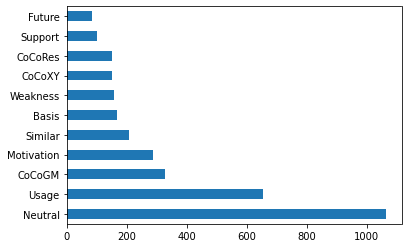

In [19]:
citation.Cit_func.value_counts().plot(kind='barh')

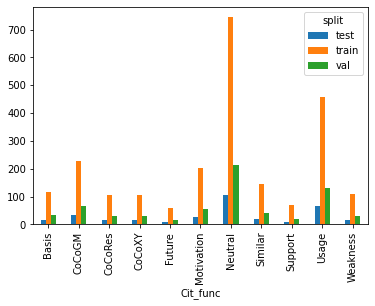

In [20]:
citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a=citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a.plot(kind='bar')

In [21]:
citation.groupby(['Cit_func','split']).size()

Cit_func    split
Basis       test      16
            train    116
            val       33
CoCoGM      test      32
            train    229
            val       65
CoCoRes     test      15
            train    105
            val       30
CoCoXY      test      15
            train    106
            val       30
Future      test       8
            train     59
            val       17
Motivation  test      28
            train    201
            val       57
Neutral     test     106
            train    744
            val      212
Similar     test      20
            train    144
            val       41
Support     test      10
            train     70
            val       20
Usage       test      65
            train    458
            val      131
Weakness    test      15
            train    110
            val       31
dtype: int64

**Tokenizer**

In [22]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizerFast.from_pretrained('/content/drive/MyDrive/scibert_scivocab_uncased')
special_tokens_dict = {'additional_special_tokens': ['CITSEG']}
tokenizer.add_special_tokens(special_tokens_dict=special_tokens_dict)

Loading BERT tokenizer...


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


0

**Splitting the dataset into three datasets: train, val, test**

In [23]:
df_train = citation[citation.split=='train']
df_val = citation[citation.split=='val']
df_test= citation[citation.split=='test']

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(2342, 6)
(667, 6)
(330, 6)


**Shuffling the data splits**

In [24]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

**Getting texts and labels**

In [25]:
sentences_train = df_train.text.values
labels_train = df_train.label.values

sentences_valid = df_val.text.values
labels_valid = df_val.label.values

sentences_test = df_test.text.values
labels_test = df_test.label.values

**Creating input ids, attention masks**

In [26]:
from keras.preprocessing.sequence import pad_sequences
def create_input_ids_attention_maks(sentences, max_len):
  input_ids = []

  # For every sentence...
  for sent in sentences:
      # `encode` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      encoded_sent = tokenizer.encode(
                          sent,                      
                          add_special_tokens = True,
                          max_length = max_len,         
                          truncation=True
                          
                    )
      
      # Add the encoded sentence to the list.
      input_ids.append(encoded_sent)

  
  # pad the sequences
  input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", 
                            value=0, truncating="post", padding="post")
  

  # Create attention masks
  attention_masks = []

  for sent in input_ids:
      
      # Create the attention mask.
      #   - If a token ID is 0, then it's padding, set the mask to 0.
      #   - If a token ID is > 0, then it's a real token, set the mask to 1.
      att_mask = [int(token_id > 0) for token_id in sent]
      
      attention_masks.append(att_mask)

  return [input_ids, attention_masks]

In [27]:
input_ids_train, attention_masks_train = create_input_ids_attention_maks(sentences_train, 500)
input_ids_valid, attention_masks_valid = create_input_ids_attention_maks(sentences_valid, 500)
input_ids_test, attention_masks_test = create_input_ids_attention_maks(sentences_test, 500)

In [28]:
input_ids_train.shape

(2342, 500)

**Calculating position of Citseg in tokenised text**

In [29]:
def calc_tok_cit_seg_id(df,input_id):
  cit_id=df['citseg_id'].values
  k=0
  tok_cid=[]
  for i in input_id:
    cit_seg_tok_id=-1
    #print(i)
    for j in i:
      #print(j)

      cit_seg_tok_id +=1
      if (j==1 and cit_seg_tok_id>= cit_id[k]):
        if(cit_seg_tok_id!= None):
          #print("cit_seg_tok_id for ", k ,"is: ", cit_seg_tok_id)
          tok_cid.append(cit_seg_tok_id)
          #print(k,len(tok_cid))
        else:
          print("no citseg")
        break
    k+=1
  #print(k)
  return tok_cid

In [30]:
id_train= calc_tok_cit_seg_id(df_train,input_ids_train)
id_val= calc_tok_cit_seg_id(df_val,input_ids_valid) 
id_test= calc_tok_cit_seg_id(df_test,input_ids_test)

In [31]:
len(id_train)

2342

**Adding Citseg position to Dataframes**

In [32]:
df_train.loc[:,'tok_citseg_id']=id_train
df_test['tok_citseg_id']=id_test
df_val.loc[:,'tok_citseg_id']=id_val

In [33]:
df_train.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[The, problem, arises, as, a, result, of, the, fact, that, these, solutions, lead, to, identical, filters, for, the, evaluation, of, the, cat, _, ~, literal, ,, i.e., ,, the, solutions, to, cat, _, 2, do, not, uniquely, determine, cat_3, ., Also, with, respect, to, the, dependency, constraint, an, optimization, of, the, rules, in, the, grammar, is, important, ., Through, reordering, the, right...",Neutral,82,"The problem arises as a result of the fact that these solutions lead to identical filters for the evaluation of the cat _ ~ literal , i.e. , the solutions to cat _ 2 do not uniquely determine cat_3 . Also with respect to the dependency constraint an optimization of the rules in the grammar is important . Through reordering the right - hand sides of the rules in the grammar the amount of nondet...",6,train,92
1,"[The, rules, mapping, from, the, unordered, dependency, trees, of, surface, -, syntactic, representations, onto, the, annotated, lexeme, sequences, of, deep-morphological, representations, include, global, ordering, rules, which, allow, discontinuities, ., These, rules, have, not, yet, been, formally, specified, (, CITSEGp.187, f, ), (, but, see, the, proposal, by, CITSEG, ), ., Word, Grammar,...",Neutral,55,"The rules mapping from the unordered dependency trees of surface - syntactic representations onto the annotated lexeme sequences of deep-morphological representations include global ordering rules which allow discontinuities . These rules have not yet been formally specified ( CITSEGp.187 f ) ( but see the proposal by CITSEG ) . Word Grammar ( WG , CITSEG ) is based on general graphs instead o...",6,train,55
2,"[The, recent, availability, of, large, amounts, of, bilingual, data, has, attracted, interest, in, several, areas, ,, including, sentence, alignment, (, CITSEG, ), ,, word, alignment, (, CITSEG, ), ,, alignment, of, groups, of, words, (, CITSEG, ), ,, and, statistical, translation, (, CITSEG, ), ., Of, these, ,, aligning, groups, of, words, is, most, similar, to, the, work, reported, here, ,, ...",Neutral,20,"The recent availability of large amounts of bilingual data has attracted interest in several areas , including sentence alignment ( CITSEG ) , word alignment ( CITSEG ) , alignment of groups of words ( CITSEG ) , and statistical translation ( CITSEG ) . Of these , aligning groups of words is most similar to the work reported here , although , as we shall show , we consider a greater variety of...",6,train,21
3,"[Re-estimation, on, any, of, the, words, in, a, class, therefore, counts, towards, re-estimation, for, all, of, them, 1., The, results, of, the, Xerox, experiment, appear, very, encouraging, ., Preparing, tagged, corpora, either, by, hand, is, labour-, intensive, and, potentially, error-prone, ,, and, although, a, semi-automatic, approach, can, be, used, (, CITSEG, ), ,, it, is, a, good, thing...",Neutral,50,"Re-estimation on any of the words in a class therefore counts towards re-estimation for all of them 1. The results of the Xerox experiment appear very encouraging . Preparing tagged corpora either by hand is labour- intensive and potentially error-prone , and although a semi-automatic approach can be used ( CITSEG ) , it is a good thing to reduce the human involvement as much as possible . How...",6,train,62
4,"[Experiment, and, Discussion, Before, the, antecedents, in, indirect, anaphora, were, determined, ,, sentences, were, transformed, into, a, case, structure, by, the, case, analyzer, (, CITSEG, ), ., The, errors, made, by, the, analyzer, were, corrected, by, hand, ., We, used, the, IPAL, dictionary, (, IPAL, ,, 1987, ), as, a, verb, case, frame, dictionary, ., We, used, the, Japanese, Co-occurr...",Usage,24,"Experiment and Discussion Before the antecedents in indirect anaphora were determined , sentences were transformed into a case structure by the case analyzer ( CITSEG ) . The errors made by the analyzer were cor

In [34]:
df_val.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[In, order, to, measure, the, contribution, of, syntactic, relations, ,, we, wanted, to, test, them, on, several, ML, algorithms, ., At, present, we, have, chosen, one, algorithm, which, does, not, combine, features, (, Decision, Lists, ), and, another, which, does, combine, features, (, AdaBoost, ), ., Despite, their, simplicity, ,, Decision, Lists, (, Dlist, for, short, ), as, defined, in, C...",Usage,60,"In order to measure the contribution of syntactic relations , we wanted to test them on several ML algorithms . At present we have chosen one algorithm which does not combine features ( Decision Lists ) and another which does combine features ( AdaBoost ) . Despite their simplicity , Decision Lists ( Dlist for short ) as defined in CITSEG have been shown to be very effective for WSD ( CITSEG )...",9,val,64
1,"[Each, entity, appearing, in, a, text, can, have, multiple, descriptions, (, up, to, several, dozen, ), associated, with, it, ., We, call, the, set, of, all, descriptions, related, to, the, same, entity, in, a, corpus, ,, a, profile, of, that, entity, ., Profiles, for, a, large, number, of, entities, were, compiled, using, our, earlier, system, ,, PRO, -, FILE, (, CITSEG, ), ., It, turns, out,...",Usage,60,"Each entity appearing in a text can have multiple descriptions ( up to several dozen ) associated with it . We call the set of all descriptions related to the same entity in a corpus , a profile of that entity . Profiles for a large number of entities were compiled using our earlier system , PRO - FILE ( CITSEG ) . It turns out that there is a large variety in the size of the profile ( number ...",9,val,62
2,"[It, has, been, noted, in, previous, work, that, the, felicity, of, certain, forms, of, ellipsis, is, dependent, on, the, type, of, coherence, relationship, extant, between, the, antecedent, and, elided, clauses, (, CITSEG, ), ., In, this, section, we, review, the, relevant, facts, for, two, such, forms, of, ellipsis, ,, namely, gapping, and, VP, -, ellipsis, ,, and, also, compare, these, with...",Neutral,31,"It has been noted in previous work that the felicity of certain forms of ellipsis is dependent on the type of coherence relationship extant between the antecedent and elided clauses ( CITSEG ) . In this section we review the relevant facts for two such forms of ellipsis , namely gapping and VP - ellipsis , and also compare these with facts concerning non-elliptical event reference . Gapping is...",6,val,35
3,"[However, ,, building, such, a, model, is, computationally, expensive, ., Since, the, space, of, possible, joint, labelings, is, exponential, in, the, number, of, parse, tree, nodes, ,, a, model, cannot, exhaustively, consider, these, labelings, unless, it, makes, strong, independence, assumptions, ., To, overcome, this, problem, ,, we, adopt, a, discriminative, re-ranking, approach, reminisce...",Usage,55,"However , building such a model is computationally expensive . Since the space of possible joint labelings is exponential in the number of parse tree nodes , a model cannot exhaustively consider these labelings unless it makes strong independence assumptions . To overcome this problem , we adopt a discriminative re-ranking approach reminiscent of ( CITSEG ) . We use a local model , which label...",9,val,61
4,"[Interannotator, agreement, rates, ranged, between, 0.84-0.93, (, Cohen, 's, Kappa, ), ., Research, has, been, carried, out, into, the, automatic, assignment, of, Manner, values, to, events, (, CITSEG, ), ., In, addition, ,, the, EventMine, -, MK, service, (, CITSEG, ), ,, based, on, EventMine, (, CITSEG, ), facilitates, automatic, extraction, of, biomedical, events, with, meta-knowledge, assi...",Neutral,46,"Interannotator agreement rates ranged between 0.84-0.93 ( Cohen 's Kappa ) . Research has been carried out into the automatic assignment of Manner values to events ( CITSEG ) . In addition , the EventMine - MK service ( CIT

In [35]:
df_test.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[Several, efficient, ,, accurate, and, robust, approaches, to, data-driven, dependency, parsing, have, been, proposed, recently, (, CITSEG, ), for, syntactic, analysis, of, natural, language, using, bilexical, dependency, relations, (, CITSEG, ), ., Much, of, the, appeal, of, these, approaches, is, tied, to, the, use, of, a, simple, formalism, ,, which, allows, for, the, use, of, efficient, pa...",Neutral,110,"Several efficient , accurate and robust approaches to data-driven dependency parsing have been proposed recently ( CITSEG ) for syntactic analysis of natural language using bilexical dependency relations ( CITSEG ) . Much of the appeal of these approaches is tied to the use of a simple formalism , which allows for the use of efficient parsing algorithms , as well as straightforward ways to tra...",6,test,123
1,"[Defeasibili~y, is, a, notion, that, is, tricky, to, deal, with, ,, and, scholars, in, logics, and, pragmatics, have, learned, to, circumvent, it, or, live, with, it, ., The, first, observers, of, the, phenomenon, preferred, to, keep, defeasibility, outside, the, mathematical, world, ., For, CITSEG, "", everything, exists, "", ;, therefore, ,, in, their, logical, systems, ,, it, is, impossible, ...",Neutral,71,"Defeasibili~y is a notion that is tricky to deal with , and scholars in logics and pragmatics have learned to circumvent it or live with it . The first observers of the phenomenon preferred to keep defeasibility outside the mathematical world . For CITSEG "" everything exists "" ; therefore , in their logical systems , it is impossible to formalize the cancellation of the presupposition that def...",6,test,84
2,"[We, examine, three, systems, :, one, that, uses, ASR, with, the, grounded, language, model, ,, a, baseline, system, that, uses, ASR, with, the, text, only, interpolated, language, model, ,, and, finally, a, system, that, uses, human, produced, closed, caption, transcriptions, to, index, events, ., For, each, system, ,, all, 1200, events, from, the, test, set, (, not, just, the, highlights, ),...",Usage,73,"We examine three systems : one that uses ASR with the grounded language model , a baseline system that uses ASR with the text only interpolated language model , and finally a system that uses human produced closed caption transcriptions to index events . For each system , all 1200 events from the test set ( not just the highlights ) are indexed . Queries are generated artificially using a meth...",9,test,78
3,"[This, paper, assumes, some, familiarity, with, the, TAG, formalism, ., (, CITSEG, ), and, (, CITSEG, ), are, good, introductions, to, the, formalism, and, its, linguistic, relevance, ., TAGs, have, been, shown, to, have, relations, with, both, phrasestructure, grammars, and, dependency, grammars, (, CITSEG, ), and, can, handle, (, non-projective, ), long, distance, dependencies, ., Consistenc...",Neutral,43,This paper assumes some familiarity with the TAG formalism . ( CITSEG ) and ( CITSEG ) are good introductions to the formalism and its linguistic relevance . TAGs have been shown to have relations with both phrasestructure grammars and dependency grammars ( CITSEG ) and can handle ( non-projective ) long distance dependencies . Consistency of probabilistic TAGs has practical significance for t...,6,test,46
4,"[The, filtering, algorithm, behaves, extremely, well, ., Although, the, worst, case, runtime, is, still, O, (, n, 4, ), ,, the, best, case, has, improved, to, n, 3, ;, empirically, it, seems, to, significantly, reduce, the, amount, of, time, spent, exploring, spans, ., Figure, 2, compares, the, speed, of, the, fast, tic-tac-, toe, algorithm, against, the, algorithm, in, CITSEG, .]",CoCoRes,58,"The filtering algorithm behaves extremely well . Although the worst case runtime is still O ( n 4 ) , the best case has improved to n 3 ; empirically it seems to significantly reduce the amount of time spent exploring spans . F

**Create torch tensors required for DataLoader**

In [36]:

train_inputs = torch.tensor(input_ids_train)
validation_inputs = torch.tensor(input_ids_valid)
citseg_train_inputs=torch.tensor(id_train)
test_inputs = torch.tensor(input_ids_test)


train_labels = torch.tensor(df_train.label.values)
validation_labels = torch.tensor(df_val.label.values)
citseg_validation_inputs=torch.tensor(id_val)
test_labels = torch.tensor(df_test.label.values)

train_masks = torch.tensor(attention_masks_train)
validation_masks = torch.tensor(attention_masks_valid)
citseg_test_inputs=torch.tensor(id_test)
test_masks = torch.tensor(attention_masks_test)

In [37]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn

batch_size = 16


# DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels,citseg_train_inputs)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,citseg_validation_inputs)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels,citseg_test_inputs)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [38]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Custom SciBert Model**

In [39]:
#Create custom scibert model for sequence classification
class CustomSciBERTModel(nn.Module):
    def __init__(self):
      super(CustomSciBERTModel, self).__init__()
      self.scibert = BertModel.from_pretrained('/content/drive/MyDrive/scibert_scivocab_uncased')
      self.num_labels = 11
      self.dropout = nn.Dropout(0.3)
      self.fc1 = nn.Linear(768, 512)
      self.relu = nn.ReLU()
      self.fc2 = nn.Linear(512, 11)
      self.act=nn.Softmax(dim=1)
      #self.linear_layer = nn.Linear(768, 11)
     

    def forward(self, ids, mask, labels,citseg_id):
      output = self.scibert(
            input_ids=ids, 
            attention_mask=mask)
      last_hidden_states = output[0]
      
      #gather function
      batch_size,columns=ids.shape
      citseg_id = citseg_id.view(batch_size,1,1)
      citseg_id = citseg_id.repeat(1,1,768)
      pooled_states2 = torch.gather(input=last_hidden_states, dim=1, index=citseg_id)
      #print("pooled_states2:", pooled_states2)
      citseg_feature_vector = torch.squeeze(pooled_states2, dim=1)

      #logits = self.linear_layer(citseg_feature_vector) 
      #print(citseg_feature_vector.shape)
      out = self.fc1(citseg_feature_vector)
      out = self.relu(out)
      out = self.fc2(out)
      logits= self.act(out)

      loss = None
      # while training return loss and while validation/ testing resturn logits
      if labels is not None:
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return loss
      else:
        return logits

In [40]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Create model object
model = CustomSciBERTModel()

# Get model on to GPU
model.cuda()

# Optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of epochs
epochs = 20

# training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value 
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at /content/drive/MyDrive/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is depre

In [41]:
# Compute accuracy
def accuracy(preds, labels):
    pred = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(pred == labels) / len(labels)

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [42]:
def macroscore(preds,labels):
  pred = np.argmax(preds, axis=1).flatten()
  labels = labels.flatten()
  val_macro_f1_score = f1_score(labels, pred, average='macro')
  return val_macro_f1_score 

In [43]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [44]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

true, pred = [], []

predictions=[]
prediction=[]
y=[]

# Store the average loss after each epoch so we can plot them.
training_loss_values = []
validation_loss_values= []

# set initial loss to infinite
best_valid_loss = float('inf')

# store predictions on validation data
valid_preds = []

max_val_f1_score=0

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains four pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        #   [3]: citseg ids 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_citseg_id=batch[3].to(device)
        

        # backward pass. PyTorch doesn't do this automatically because 
        model.zero_grad()        

        # Forward pass
        outputs = model(ids = b_input_ids, mask = b_input_mask, labels = b_labels, citseg_id=b_citseg_id)
        
        # forward pass gives loss as output
        loss = outputs

        # accumulate loss
        total_loss += loss.item()

        # backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0. to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    training_loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Reset the total validation loss for this epoch.
    total_valid_loss = 0

    # evaluation mode.
    model.eval()

    # evaluation loss and accuracy
    eval_loss, eval_accuracy = 0, 0
    running_loss, running_acc= 0 , 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels,b_citseg_id = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # It gives logits when labels are not given to model
            outputs = model(b_input_ids, 
                            b_input_mask, labels = None, citseg_id=b_citseg_id)
        
        # Get the "logits" output by the model. The "logits" are the output
        logits = outputs

        # Track the number of batches
        nb_eval_steps += 1

        # compute the loss
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, b_labels)
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (nb_eval_steps)    

        # Calculate the average loss over the validating data.
        # accumulate loss
        total_valid_loss += loss.item()
        avg_valid_loss = total_valid_loss / len(validation_dataloader)
         
         #save the best model
        if avg_valid_loss < best_valid_loss:
          best_valid_loss = avg_valid_loss
          torch.save(model.state_dict(), 'saved_weights.pt') 

        

        #appending predictions and true labels for last epoch
        if(epoch_i==epochs-1):
          _, predictions = logits.max(dim=1)
          prediction.append(predictions)
          y.append(b_labels)

        #compute the accuracy
        acc_t = compute_accuracy(logits, b_labels)
        running_acc += (acc_t - running_acc) / (nb_eval_steps)


        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        valid_preds.extend(np.argmax(logits, axis=1).flatten())
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        #calculate macro f1 score
        val_f1_score=macroscore(logits, label_ids)

        if val_f1_score>max_val_f1_score:
          max_val_f1_score=val_f1_score

        

    # Store the loss value for plotting the learning curve.
    validation_loss_values.append(avg_valid_loss)
    
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Average Validation loss: {0:.2f}".format(avg_valid_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    print("The Val macro f1 score is: ", max_val_f1_score)
    print('Epoch {}\t val_loss={}\t val_acc={}'.format(epoch_i, running_loss, running_acc))
      
    

print("")
print("Training complete!")


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:34.
  Batch    80  of    147.    Elapsed: 0:01:08.
  Batch   120  of    147.    Elapsed: 0:01:42.

  Average training loss: 2.20
  Training epcoh took: 0:02:04

Running Validation...
  Accuracy: 0.45
  Average Validation loss: 2.10
  Validation took: 0:00:14
The Val macro f1 score is:  0.31142857142857144
Epoch 0	 val_loss=2.0969985723495483	 val_acc=44.96753246753247

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:34.
  Batch    80  of    147.    Elapsed: 0:01:08.
  Batch   120  of    147.    Elapsed: 0:01:42.

  Average training loss: 2.09
  Training epcoh took: 0:02:05

Running Validation...
  Accuracy: 0.45
  Average Validation loss: 2.09
  Validation took: 0:00:12
The Val macro f1 score is:  0.35238095238095235
Epoch 1	 val_loss=2.090713580449423	 val_acc=44.899891774891785

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:

In [45]:
training_loss_values 

[2.1978409630911693,
 2.0920945568149594,
 2.0496828653374495,
 1.9642839666937484,
 1.90913234762594,
 1.8695622131127079,
 1.8425359555653162,
 1.8273086101830411,
 1.8078084713747713,
 1.782024463828729,
 1.7603578583723833,
 1.739405734198434,
 1.7112944085581774,
 1.689788210148714,
 1.676936924863024,
 1.6625572856591673,
 1.6470156640422589,
 1.6328534431198016,
 1.6305760866930696,
 1.625031963497603]

In [46]:
validation_loss_values

[2.0969985723495483,
 2.0907135804494223,
 2.0276216807819547,
 2.009627958138784,
 1.9694460602033705,
 1.9561618935494196,
 1.9665489508992149,
 1.9591532122521174,
 1.9393485983212788,
 1.9294296446300687,
 1.9270426489057995,
 1.9127869577634902,
 1.9021655122439067,
 1.8974079858689081,
 1.9030853907267253,
 1.8961520053091503,
 1.8931205414590382,
 1.8926967070216225,
 1.889703719388871,
 1.8879985894475664]

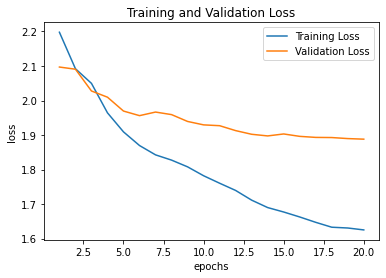

In [52]:
import matplotlib.pyplot as plt
# line 1 points
x1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
y1 = training_loss_values
# plotting the line 1 points 
plt.plot(x1, y1, label = "Training Loss")
# line 2 points

y2 = validation_loss_values
# plotting the line 2 points 
plt.plot(x1, y2, label = "Validation Loss")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# Set a title of the current axes.
plt.title('Training and Validation Loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [47]:
y.pop()

tensor([10,  9,  9,  6,  5,  9,  6,  9,  1, 10,  9], device='cuda:0')

In [48]:
prediction.pop()

tensor([ 5,  9,  9,  6,  5,  9,  6,  8,  1, 10,  9], device='cuda:0')

In [49]:
y_tensor = torch.stack(y)
pred_tensor = torch.stack(prediction)

In [50]:
true_y=y_tensor.cpu().detach().numpy()
pred_y=pred_tensor.cpu().detach().numpy()

In [51]:
true_y.shape

(41, 16)

In [53]:
pred_y=pred_y.flatten()

In [54]:
true_y=true_y.flatten()

In [55]:
from sklearn.metrics import classification_report
target_names = ["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"]
#target_names = ["Future","Neut","PSim","compare_contrast","support"]
print(classification_report(true_y, pred_y, target_names=target_names))

              precision    recall  f1-score   support

       Basis       0.50      0.55      0.52        33
      CoCoGM       0.69      0.64      0.67        64
     CoCoRes       0.80      0.67      0.73        30
      CoCoXY       0.20      0.33      0.25        30
      Future       0.57      0.76      0.65        17
  Motivation       0.55      0.64      0.60        56
     Neutral       0.74      0.67      0.70       210
     Similar       0.65      0.68      0.67        41
     Support       0.53      0.40      0.46        20
       Usage       0.84      0.76      0.80       126
    Weakness       0.47      0.62      0.54        29

    accuracy                           0.65       656
   macro avg       0.60      0.61      0.60       656
weighted avg       0.68      0.65      0.66       656



In [56]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

In [57]:
cf_matrix

array([[ 18,   0,   0,   1,   1,   1,   3,   1,   0,   6,   2],
       [  2,  41,   0,   6,   1,   2,   1,   3,   1,   2,   5],
       [  0,   0,  20,   4,   0,   0,   3,   2,   0,   0,   1],
       [  1,   4,   2,  10,   0,   1,   6,   3,   1,   0,   2],
       [  2,   0,   1,   0,  13,   0,   0,   1,   0,   0,   0],
       [  0,   3,   0,   3,   0,  36,  11,   0,   2,   0,   1],
       [  7,   6,   1,  19,   4,  12, 140,   2,   3,   8,   8],
       [  2,   2,   0,   2,   0,   0,   4,  28,   0,   2,   1],
       [  0,   0,   0,   0,   2,   6,   3,   1,   8,   0,   0],
       [  4,   1,   1,   4,   2,   6,  10,   2,   0,  96,   0],
       [  0,   2,   0,   1,   0,   1,   7,   0,   0,   0,  18]])

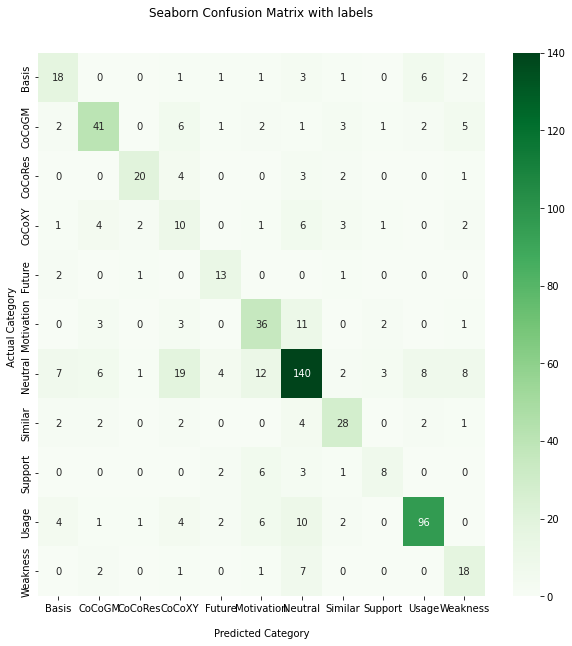

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 9))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"])
ax.yaxis.set_ticklabels(["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"])

## Display the visualization of the Confusion Matrix.
plt.show()

**Testing**

In [59]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [60]:
tot_pred=[]
tot_labels=[]
input_ids=[]

for batch in test_dataloader:
        
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_citseg_id = batch
    
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # It gives logits when labels are not given to model
        outputs = model(b_input_ids, 
                        b_input_mask, labels = None, citseg_id=b_citseg_id)
    
    # Get the "logits" output by the model. The "logits" are the output
    #logits = outputs
    _, logits = outputs.max(dim=1)
    tot_pred.append(logits)
    tot_labels.append(b_labels)
    input_ids.append(b_input_ids)

In [61]:
tot_labels.pop()

tensor([2, 6, 8, 3, 9, 9, 9, 1, 6, 6], device='cuda:0')

In [62]:
tot_pred.pop()

tensor([2, 7, 8, 1, 9, 9, 9, 1, 7, 6], device='cuda:0')

In [63]:
input_ids.pop()

tensor([[ 102,  185, 3226,  ...,    0,    0,    0],
        [ 102,  111, 3619,  ...,    0,    0,    0],
        [ 102,  694,  422,  ...,    0,    0,    0],
        ...,
        [ 102,  111, 1150,  ...,    0,    0,    0],
        [ 102, 1920,  198,  ...,    0,    0,    0],
        [ 102,  185,  220,  ...,    0,    0,    0]], device='cuda:0')

In [64]:
tot_labels_tensor = torch.stack(tot_labels)
tot_pred_tensor = torch.stack(tot_pred)
input_ids_tensor=torch.stack(input_ids)

In [65]:
true_y=tot_labels_tensor.cpu().detach().numpy()
pred_y=tot_pred_tensor.cpu().detach().numpy()
input_id=input_ids_tensor.cpu().detach().numpy()

In [66]:
sent=[]
for i in (input_ids_tensor):
  for j in i:
    x=tokenizer.convert_ids_to_tokens(j)
    #print(x)
    sent.append(x)

In [67]:
true_y.shape

(20, 16)

In [68]:
true_y=true_y.flatten()
pred_y=pred_y.flatten()


In [69]:
len(sent)

320

In [70]:
from sklearn.metrics import classification_report
target_names = ["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"]
#target_names = ["Future","Neut","PSim","compare_contrast","support"]
print(classification_report(true_y, pred_y, target_names=target_names))

              precision    recall  f1-score   support

       Basis       0.53      0.50      0.52        16
      CoCoGM       0.70      0.61      0.66        31
     CoCoRes       0.79      0.79      0.79        14
      CoCoXY       0.00      0.00      0.00        14
      Future       0.88      0.88      0.88         8
  Motivation       0.45      0.68      0.54        28
     Neutral       0.78      0.74      0.76       103
     Similar       0.58      0.70      0.64        20
     Support       0.50      0.78      0.61         9
       Usage       0.78      0.81      0.79        62
    Weakness       0.43      0.40      0.41        15

    accuracy                           0.68       320
   macro avg       0.58      0.62      0.60       320
weighted avg       0.66      0.68      0.67       320



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

In [72]:
cf_matrix

array([[ 8,  0,  0,  0,  0,  2,  0,  0,  0,  5,  1],
       [ 2, 19,  1,  0,  0,  1,  2,  4,  0,  0,  2],
       [ 0,  1, 11,  0,  0,  1,  0,  0,  0,  0,  1],
       [ 0,  2,  1,  0,  0,  3,  2,  0,  1,  3,  2],
       [ 0,  0,  0,  0,  7,  0,  0,  0,  1,  0,  0],
       [ 1,  1,  0,  0,  0, 19,  4,  1,  0,  0,  2],
       [ 2,  2,  0,  0,  1, 11, 76,  3,  4,  4,  0],
       [ 0,  1,  0,  0,  0,  0,  3, 14,  1,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  7,  0,  0],
       [ 2,  1,  1,  0,  0,  0,  6,  2,  0, 50,  0],
       [ 0,  0,  0,  0,  0,  5,  3,  0,  0,  1,  6]])

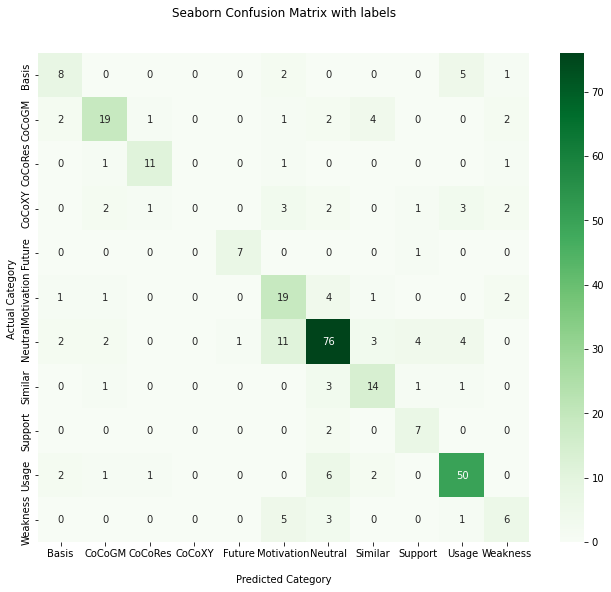

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 9))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"])
ax.yaxis.set_ticklabels(["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [74]:
df=pd.DataFrame()
df['Actual Label']= true_y
df['Tokenised Text']=sent
df['predictions']= pred_y

In [75]:
df

,Actual Label,Tokenised Text,predictions
0,6,"[[CLS], several, efficient, ,, accurate, and, robust, approaches, to, data, -, driven, dependency, parsing, have, been, proposed, recently, (, CITSEG, ), for, syntactic, analysis, of, natural, language, using, bile, ##xi, ##cal, dependency, relations, (, CITSEG, ), ., much, of, the, appeal, of, these, approaches, is, tied, to, the, use, of, a, simple, formalism, ,, which, allows, for, the, use...",6
1,6,"[[CLS], defe, ##asi, ##bil, ##i, ~, y, is, a, notion, that, is, trick, ##y, to, deal, with, ,, and, scholars, in, logics, and, pragmatic, ##s, have, learned, to, circumvent, it, or, live, with, it, ., the, first, observers, of, the, phenomenon, preferred, to, keep, defe, ##asi, ##bility, outside, the, mathematical, world, ., for, CITSEG, "", everything, exists, "", ;, therefore, ,, in, their, lo...",6
2,9,"[[CLS], we, examine, three, systems, :, one, that, uses, as, ##r, with, the, grounded, language, model, ,, a, baseline, system, that, uses, as, ##r, with, the, text, only, interpolated, language, model, ,, and, finally, a, system, that, uses, human, produced, closed, cap, ##tion, transcription, ##s, to, index, events, ., for, each, system, ,, all, 1200, events, from, the, test, set, (, not, ju...",9
3,6,"[[CLS], this, paper, assumes, some, familiarity, with, the, tag, formalism, ., (, CITSEG, ), and, (, CITSEG, ), are, good, introduction, ##s, to, the, formalism, and, its, linguistic, relevance, ., tags, have, been, shown, to, have, relations, with, both, phrases, ##tructure, grammars, and, dependency, grammars, (, CITSEG, ), and, can, handle, (, non, -, projective, ), long, distance, dependen...",6
4,2,"[[CLS], the, filtering, algorithm, behaves, extremely, well, ., although, the, worst, case, runtime, is, still, o, (, n, 4, ), ,, the, best, case, has, improved, to, n, 3, ;, empirically, it, seems, to, significantly, reduce, the, amount, of, time, spent, exploring, spans, ., figure, 2, compares, the, speed, of, the, fast, tic, -, tac, -, toe, algorithm, against, the, algorithm, in, CITSEG, .,...",2
5,10,"[[CLS], 3, ., we, derive, a, probabilistic, weakly, supervised, learning, model, and, use, it, to, motivate, our, approach, ., 4, ., we, analyze, our, learning, model, experimentally, and, report, promising, results, for, the, task, on, a, new, publicly, -, available, dataset, ., 1, scientific, text, ,, eg, ., (, CITSEG, ), ,, there, is, little, of, direct, relevance, to, the, task, of, classi...",10
6,6,"[[CLS], a, few, that, we, tested, are, described, in, the, appendix, ,, and, we, propose, some, others, in, the, next, section, ., we, should, mention, that, we, have, not, yet, experiment, ##ed, with, all, -, vs, ., -, all, (, av, ##a, ), ,, another, standard, binary, -, tom, ##ulti, -, category, classifier, conversion, method, ,, because, we, wish, ##ed, to, focus, on, the, effect, of, omit,...",8
7,6,"[[CLS], the, work, of, CITSEG, enabled, bre, ##iman, ', s, refinement, and, application, of, their, techniques, for, machine, learning, (, CITSEG, ), ., his, technique, is, called, bag, ##ging, ,, short, for, "", bootstrap, aggreg, ##ating, "", ., in, brief, ,, bootstrap, techniques, and, bag, -, ging, in, particular, reduce, the, systematic, biases, many, estimation, techniques, introduce, by, ...",6
8,9,"[[CLS], some, words, ,, and, some, sequences, of, words, such, as, "", san, francisco, "", ,, were, replaced, by, class, names, to, improve, performance, ., the, improvement, (, if, any, ), due, to, clustering, was, measured, by, using, the, various, language, models, to, make, selections, from, n, -, best, sentence, hypothesis, lists, ;, this, choice, of, test, was, made, for, convenience, rath...",9
9,6,"[[CLS], in, computational, linguistic, literature, ,, much, effort, has, been, devoted, to, phonetic, transl, ##iter, ##ation, ,, such, as, english, -, arabic, ,, english, -, chinese, (, CITSEG, ), ,, english, -, japanese, (, CITSEG, ), and, english, -, korean, ., in, g, ##

In [76]:
df['predictions'].replace({0: "Basis",1: "CoCoGM",2:  "CoCoRes", 3:"CoCoXY", 4: "Future", 5: "Motivation", 6: "Neutral", 7:"Similar", 8:"Support",9: "Usage", 10:"Weakness"}, inplace=True)
df['Actual Label'].replace({0: "Basis",1: "CoCoGM",2:  "CoCoRes", 3:"CoCoXY", 4: "Future", 5: "Motivation", 6: "Neutral", 7:"Similar", 8:"Support",9: "Usage", 10:"Weakness"}, inplace=True)

In [77]:
df

,Actual Label,Tokenised Text,predictions
0,Neutral,"[[CLS], several, efficient, ,, accurate, and, robust, approaches, to, data, -, driven, dependency, parsing, have, been, proposed, recently, (, CITSEG, ), for, syntactic, analysis, of, natural, language, using, bile, ##xi, ##cal, dependency, relations, (, CITSEG, ), ., much, of, the, appeal, of, these, approaches, is, tied, to, the, use, of, a, simple, formalism, ,, which, allows, for, the, use...",Neutral
1,Neutral,"[[CLS], defe, ##asi, ##bil, ##i, ~, y, is, a, notion, that, is, trick, ##y, to, deal, with, ,, and, scholars, in, logics, and, pragmatic, ##s, have, learned, to, circumvent, it, or, live, with, it, ., the, first, observers, of, the, phenomenon, preferred, to, keep, defe, ##asi, ##bility, outside, the, mathematical, world, ., for, CITSEG, "", everything, exists, "", ;, therefore, ,, in, their, lo...",Neutral
2,Usage,"[[CLS], we, examine, three, systems, :, one, that, uses, as, ##r, with, the, grounded, language, model, ,, a, baseline, system, that, uses, as, ##r, with, the, text, only, interpolated, language, model, ,, and, finally, a, system, that, uses, human, produced, closed, cap, ##tion, transcription, ##s, to, index, events, ., for, each, system, ,, all, 1200, events, from, the, test, set, (, not, ju...",Usage
3,Neutral,"[[CLS], this, paper, assumes, some, familiarity, with, the, tag, formalism, ., (, CITSEG, ), and, (, CITSEG, ), are, good, introduction, ##s, to, the, formalism, and, its, linguistic, relevance, ., tags, have, been, shown, to, have, relations, with, both, phrases, ##tructure, grammars, and, dependency, grammars, (, CITSEG, ), and, can, handle, (, non, -, projective, ), long, distance, dependen...",Neutral
4,CoCoRes,"[[CLS], the, filtering, algorithm, behaves, extremely, well, ., although, the, worst, case, runtime, is, still, o, (, n, 4, ), ,, the, best, case, has, improved, to, n, 3, ;, empirically, it, seems, to, significantly, reduce, the, amount, of, time, spent, exploring, spans, ., figure, 2, compares, the, speed, of, the, fast, tic, -, tac, -, toe, algorithm, against, the, algorithm, in, CITSEG, .,...",CoCoRes
5,Weakness,"[[CLS], 3, ., we, derive, a, probabilistic, weakly, supervised, learning, model, and, use, it, to, motivate, our, approach, ., 4, ., we, analyze, our, learning, model, experimentally, and, report, promising, results, for, the, task, on, a, new, publicly, -, available, dataset, ., 1, scientific, text, ,, eg, ., (, CITSEG, ), ,, there, is, little, of, direct, relevance, to, the, task, of, classi...",Weakness
6,Neutral,"[[CLS], a, few, that, we, tested, are, described, in, the, appendix, ,, and, we, propose, some, others, in, the, next, section, ., we, should, mention, that, we, have, not, yet, experiment, ##ed, with, all, -, vs, ., -, all, (, av, ##a, ), ,, another, standard, binary, -, tom, ##ulti, -, category, classifier, conversion, method, ,, because, we, wish, ##ed, to, focus, on, the, effect, of, omit,...",Support
7,Neutral,"[[CLS], the, work, of, CITSEG, enabled, bre, ##iman, ', s, refinement, and, application, of, their, techniques, for, machine, learning, (, CITSEG, ), ., his, technique, is, called, bag, ##ging, ,, short, for, "", bootstrap, aggreg, ##ating, "", ., in, brief, ,, bootstrap, techniques, and, bag, -, ging, in, particular, reduce, the, systematic, biases, many, estimation, techniques, introduce, by, ...",Neutral
8,Usage,"[[CLS], some, words, ,, and, some, sequences, of, words, such, as, "", san, francisco, "", ,, were, replaced, by, class, names, to, improve, performance, ., the, improvement, (, if, any, ), due, to, clustering, was, measured, by, using, the, various, language, models, to, make, selections, from, n, -, best, sentence, hypothesis, lists, ;, this, choice, of, test, was, made, for, convenience, rath...",Usage
9,Neutral,"[[CLS], in, computational, linguistic, literature, ,, much, effort, has, been, devoted, to, phonetic, transl, ##iter, ##ation, ,, such, as, english, -, arabic, ,, engli